In [ ]:
!pip install kagglehub opencv-python scikit-image matplotlib

In [ ]:
import kagglehub

path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

print("Dataset path:", path)

100%|██████████| 28.0M/28.0M [00:01<00:00, 21.4MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects, skeletonize


Text(0.5, 1.0, 'Ground Truth')

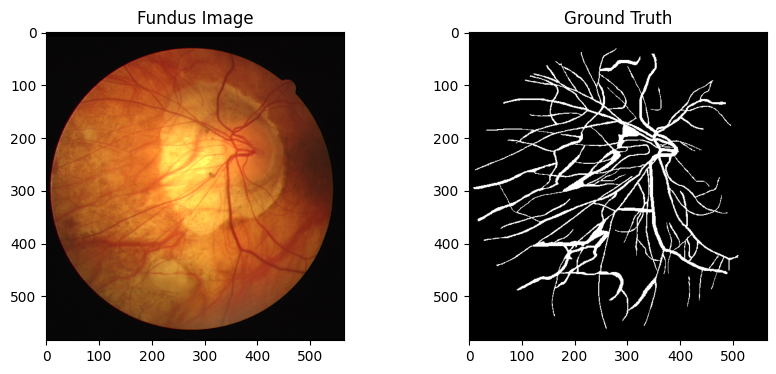

In [ ]:
IMAGE_PATH = os.path.join(path, "DRIVE", "training", "images")
MASK_PATH  = os.path.join(path, "DRIVE", "training", "1st_manual")

img_name = os.listdir(IMAGE_PATH)[0]

image = cv2.imread(os.path.join(IMAGE_PATH, img_name))

# Correctly derive mask filename from image filename
base_name = img_name.split('_')[0] # Extracts '34' from '34_training.tif'
mask_filename = f"{base_name}_manual1.gif" # Constructs '34_manual1.gif'
mask_full_path = os.path.join(MASK_PATH, mask_filename)

mask  = cv2.imread(mask_full_path, 0)

# Add a check to ensure mask was loaded correctly
if mask is None:
    print(f"Warning: Could not load mask image from {mask_full_path}. Using a black placeholder mask.")
    # As a fallback, create a black image of the same size as the original image
    if image is not None:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
    else:
        raise FileNotFoundError(f"Could not load primary image or mask image: {mask_full_path}")


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Fundus Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth")

(np.float64(-0.5), np.float64(564.5), np.float64(583.5), np.float64(-0.5))

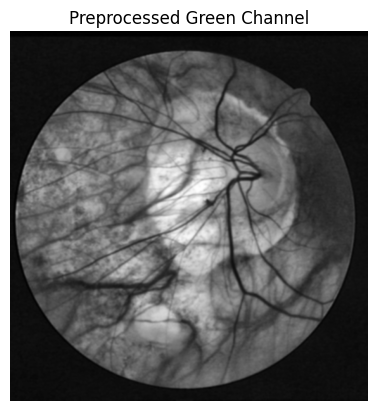

In [ ]:
# Green channel extraction
green = image[:,:,1]

# CLAHE contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
green = clahe.apply(green)

# Gaussian blur
green = cv2.GaussianBlur(green, (5,5), 0)

plt.imshow(green, cmap="gray")
plt.title("Preprocessed Green Channel")
plt.axis("off")

(np.float64(-0.5), np.float64(564.5), np.float64(583.5), np.float64(-0.5))

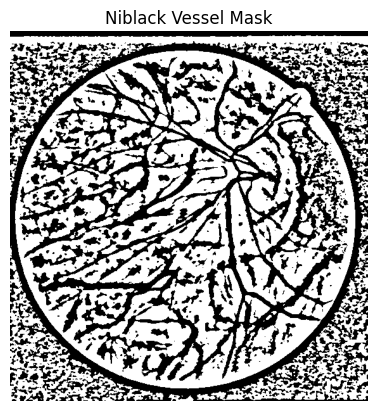

In [ ]:
window = 25
k = 0.2

th_niblack = threshold_niblack(green, window_size=window, k=k)
niblack = green > th_niblack

plt.imshow(niblack, cmap="gray")
plt.title("Niblack Vessel Mask")
plt.axis("off")

(np.float64(-0.5), np.float64(564.5), np.float64(583.5), np.float64(-0.5))

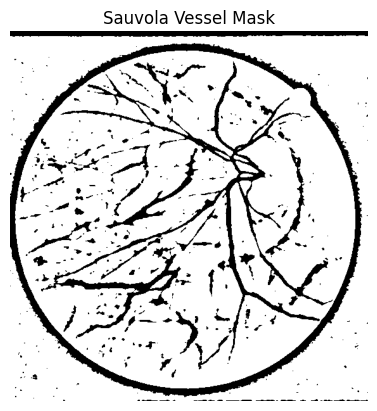

In [ ]:
th_sauvola = threshold_sauvola(green, window_size=window, k=0.2)
sauvola = green > th_sauvola

plt.imshow(sauvola, cmap="gray")
plt.title("Sauvola Vessel Mask")
plt.axis("off")

In [ ]:
niblack_clean = remove_small_objects(niblack, 50)
sauvola_clean = remove_small_objects(sauvola, 50)

# Skeletonization
niblack_skel = skeletonize(niblack_clean)
sauvola_skel = skeletonize(sauvola_clean)

Text(0.5, 1.0, 'Sauvola Result')

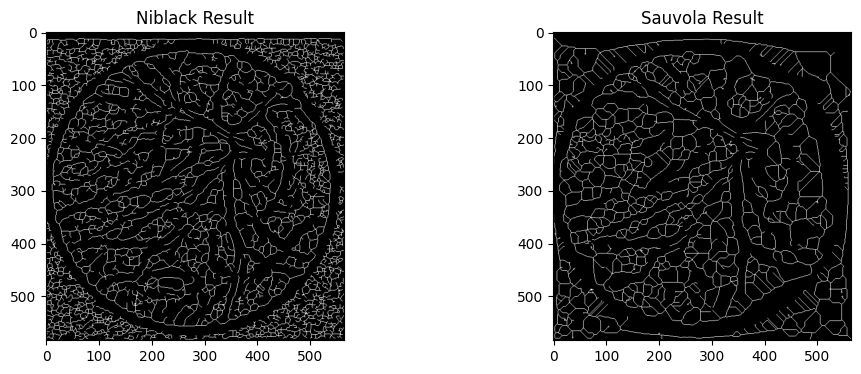

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(niblack_skel, cmap="gray")
plt.title("Niblack Result")

plt.subplot(1,2,2)
plt.imshow(sauvola_skel, cmap="gray")
plt.title("Sauvola Result")

In [ ]:
mask_bin = mask > 0

def dice(pred, gt):
    return 2*np.sum(pred & gt) / (np.sum(pred) + np.sum(gt) + 1e-8)

def sensitivity(pred, gt):
    TP = np.sum(pred & gt)
    FN = np.sum(~pred & gt)
    return TP / (TP + FN + 1e-8)

def accuracy(pred, gt):
    return np.sum(pred == gt) / gt.size

print("Niblack Dice:", dice(niblack_clean, mask_bin))
print("Sauvola Dice:", dice(sauvola_clean, mask_bin))

print("Niblack Sensitivity:", sensitivity(niblack_clean, mask_bin))
print("Sauvola Sensitivity:", sensitivity(sauvola_clean, mask_bin))

print("Niblack Accuracy:", accuracy(niblack_clean, mask_bin))
print("Sauvola Accuracy:", accuracy(sauvola_clean, mask_bin))

Niblack Dice: 0.05461547952690433
Sauvola Dice: 0.09502592614116687
Niblack Sensitivity: 0.19193483445343576
Sauvola Sensitivity: 0.45578715891830895
Niblack Accuracy: 0.34980603709540553
Sauvola Accuracy: 0.1505212753060977


**CONCLUSION**

In this experiment, retinal vessel extraction was performed using Niblack and Sauvola thresholding on DRIVE fundus images. The visual results showed that Niblack detected many vessel-like pixels but introduced heavy noise and false positives, leading to fragmented segmentation. This is reflected in its low performance metrics (Dice = 0.054, Sensitivity = 0.19).

In comparison, Sauvola produced cleaner vessel masks with better continuity of major vessels and reduced background noise. The quantitative results also support this observation, as Sauvola achieved a higher Dice (0.095) and significantly better sensitivity (0.456), indicating improved detection of true vessel pixels.

Final Result: Sauvola thresholding performed better than Niblack for thin vessel extraction, although both methods showed limitations in accurately capturing very fine vessels.